In [1]:
import numpy as np
from keras.applications.vgg16 import VGG16
import keras
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.utils import to_categorical
import matplotlib.pyplot as plt

%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN 5110)


In [2]:
data = np.load("./data.npy")
labels = np.load("./labels.npy")

print data.shape
print labels.shape

(12500L, 224L, 224L, 3L)
(12500L,)


In [3]:
labels = to_categorical(labels)
print labels.shape

(12500L, 2L)


In [4]:
def preprocess_input(image):
    image = image[:, :, :, ::-1] #RGB to BGR
    image[:, :, :, 0] -= 103.939 #zero-centering the data
    image[:, :, :, 1] -= 116.779
    image[:, :, :, 2] -= 123.68
    return image

data = preprocess_input(data)

In [5]:
split = int(0.80 * data.shape[0])
x_train = data[:split, :, :, :]
x_test = data[split:, :, :, :]

y_train = labels[:split]
y_test = labels[split:]

# x_train = data[:1000, :, :, :]
# x_test = data[1000:2000, :, :, :]

# y_train = labels[:1000]
# y_test = labels[1000:2000]

print x_train.shape, y_train.shape
print x_test.shape, y_test.shape

(10000L, 224L, 224L, 3L) (10000L, 2L)
(2500L, 224L, 224L, 3L) (2500L, 2L)


In [11]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [12]:
x = Flatten()(base_model.output)
x = Dense(512)(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)
x = Dense(2)(x)
x = Activation('softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

adam = Adam(lr=0.00003)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
for ix in range(len(model.layers)):
    print ix, model.layers[ix]

0 <keras.engine.topology.InputLayer object at 0x0000000039260C88>
1 <keras.layers.convolutional.Conv2D object at 0x00000000392607B8>
2 <keras.layers.convolutional.Conv2D object at 0x0000000039260E48>
3 <keras.layers.pooling.MaxPooling2D object at 0x000000003A08AF98>
4 <keras.layers.convolutional.Conv2D object at 0x000000003A107668>
5 <keras.layers.convolutional.Conv2D object at 0x000000003A107710>
6 <keras.layers.pooling.MaxPooling2D object at 0x000000003A1C7828>
7 <keras.layers.convolutional.Conv2D object at 0x000000003A28AFD0>
8 <keras.layers.convolutional.Conv2D object at 0x000000003A28A9B0>
9 <keras.layers.convolutional.Conv2D object at 0x000000003A39AB70>
10 <keras.layers.pooling.MaxPooling2D object at 0x0000000039243E80>
11 <keras.layers.convolutional.Conv2D object at 0x000000003A5235F8>
12 <keras.layers.convolutional.Conv2D object at 0x000000003A4C11D0>
13 <keras.layers.convolutional.Conv2D object at 0x000000003A5D5B70>
14 <keras.layers.pooling.MaxPooling2D object at 0x000000003

In [14]:
for ix in range(14):
    model.layers[ix].trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
hist = model.fit(x_train, y_train, shuffle=True, batch_size=16, epochs=2, validation_data=(x_test, y_test))

Train on 10000 samples, validate on 2500 samples
Epoch 1/2
10000/10000 [==============================] - 913s - loss: 0.5010 - acc: 0.8409 - val_loss: 0.1334 - val_acc: 0.9444
Epoch 2/2
10000/10000 [==============================] - 966s - loss: 0.0988 - acc: 0.9633 - val_loss: 0.0814 - val_acc: 0.9628


In [16]:
model.save_weights("./finetuning.h5")

In [17]:
model.layers

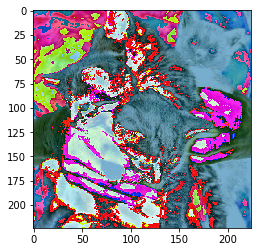

In [18]:
plt.figure(0)
plt.imshow(x_train[500])
plt.show()

In [22]:
first_block = Model(inputs=model.input, outputs=model.layers[1].output)
first_block.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792.0
Trainable params: 0.0
Non-trainable params: 1,792.0
_________________________________________________________________


(1L, 224L, 224L, 64L)


ValueError: cannot reshape array of size 50176 into shape (220,220)

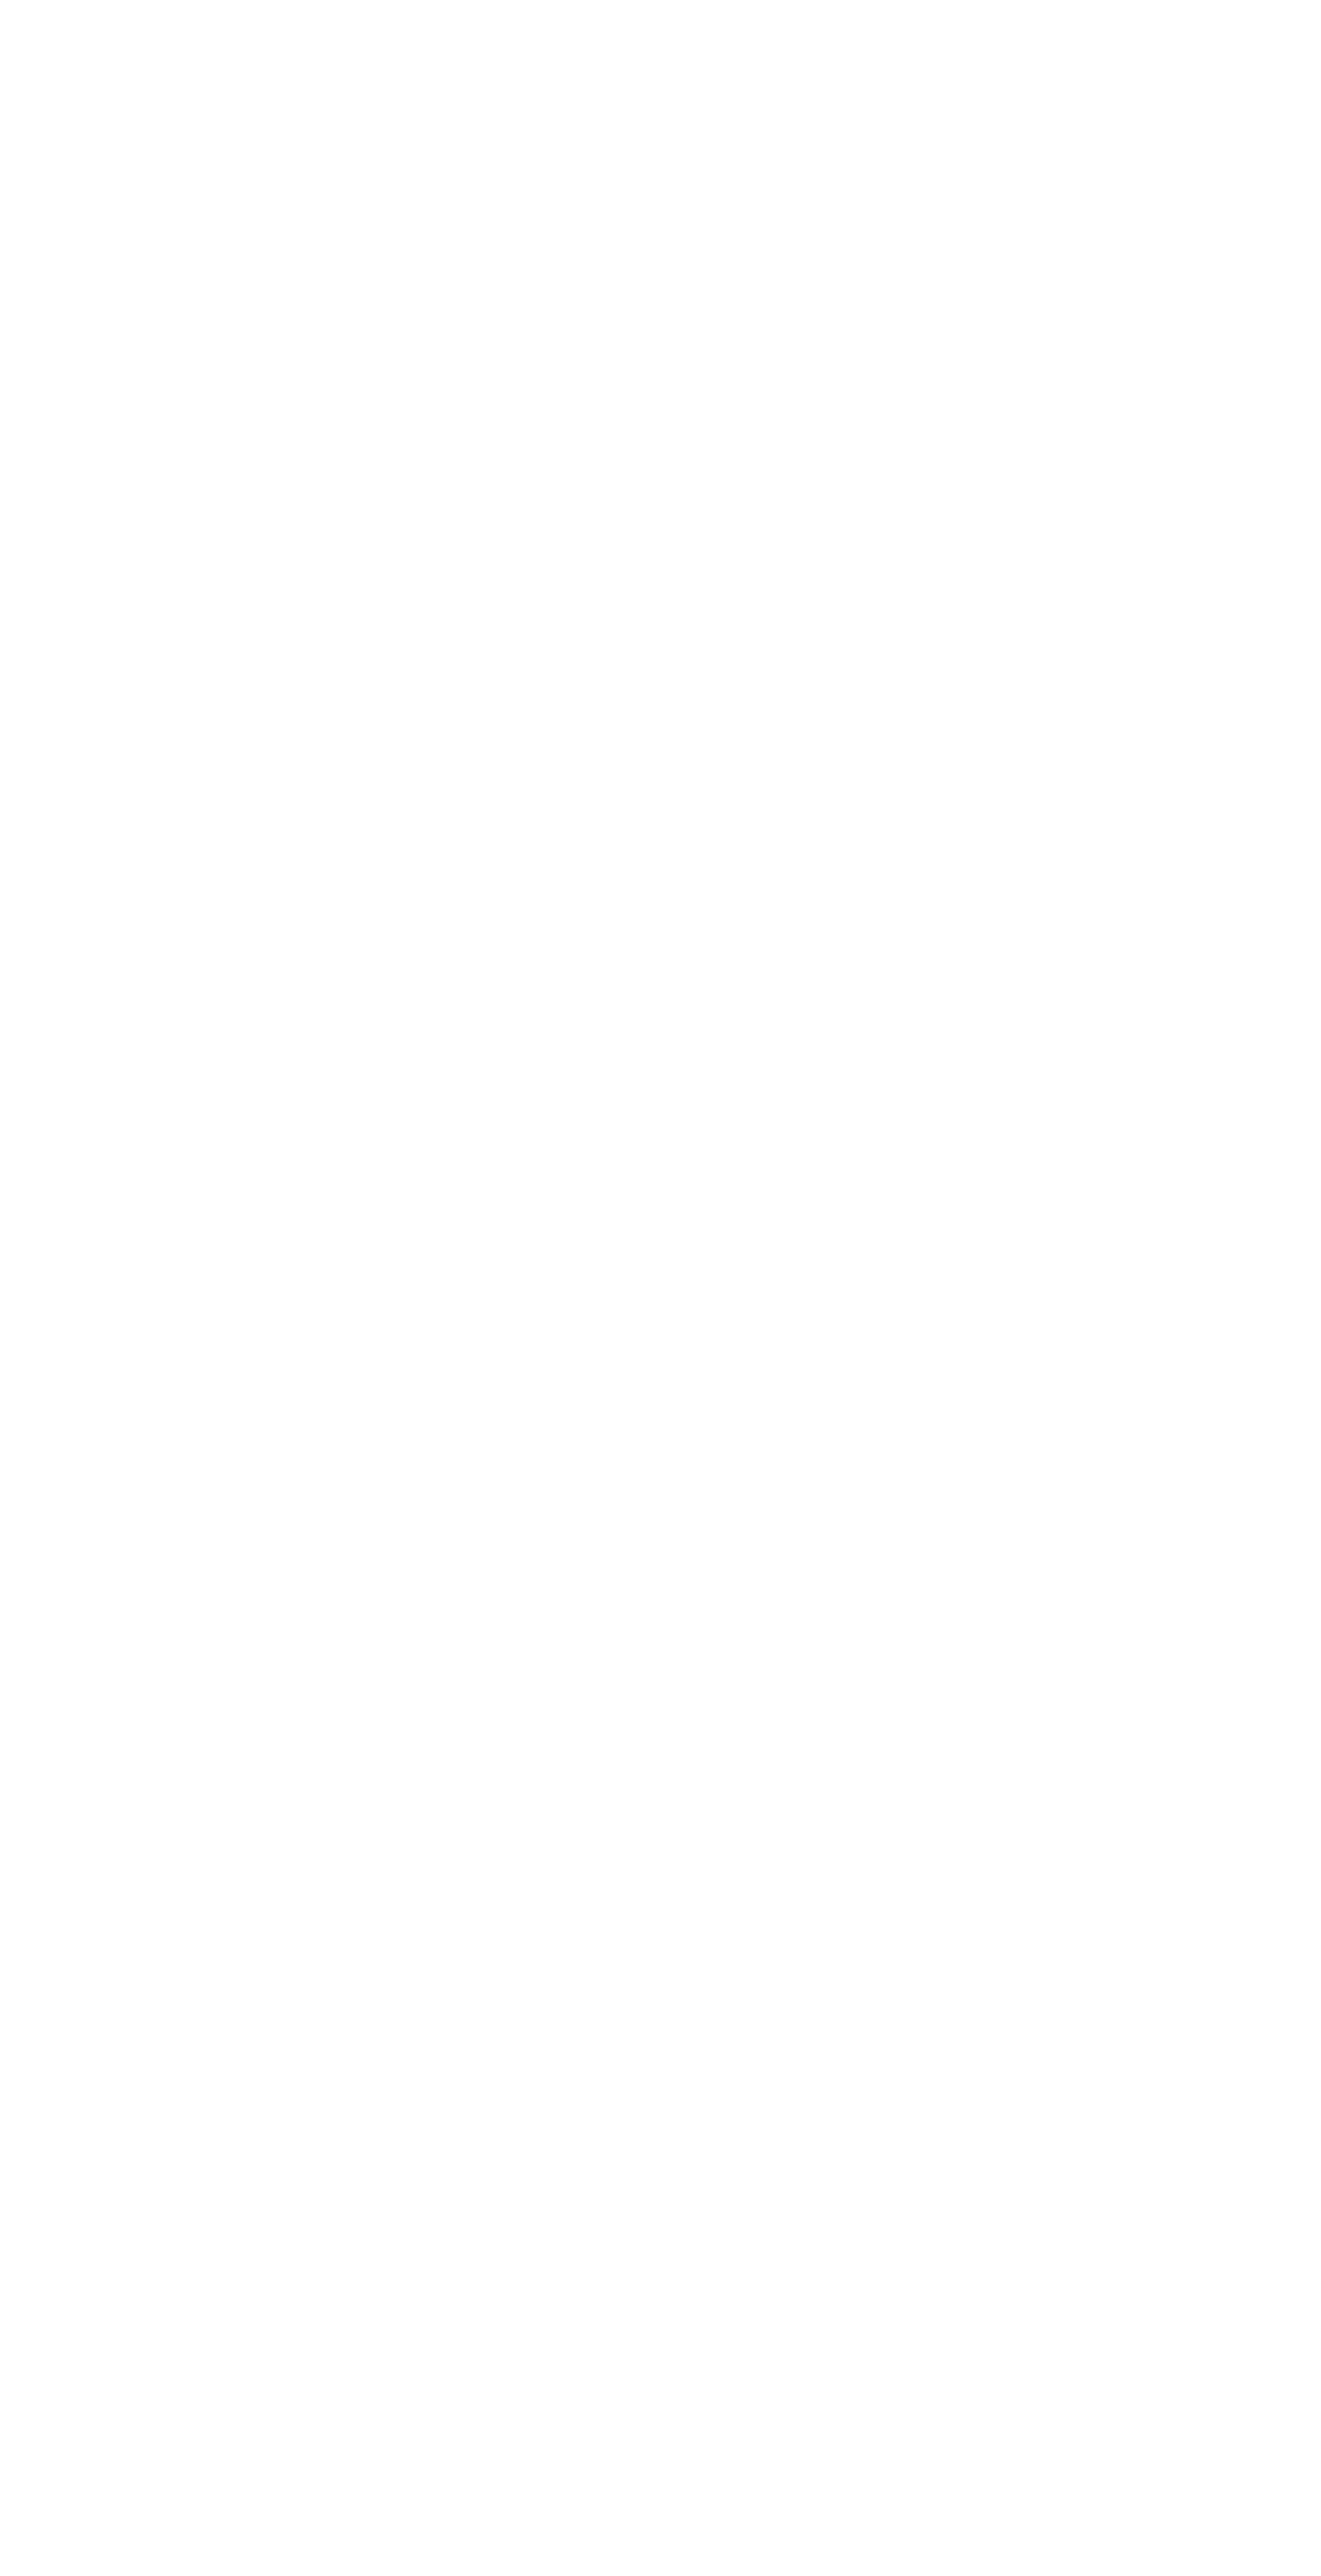

In [23]:
out = first_block.predict(x_train[500, :, :, :].reshape((-1, 224, 224, 3)))
print out.shape

plt.figure(figsize=(220,220))
for ix in range(out.shape[3]):
    plt.subplot(4, 8, ix+1)
    plt.axis('off')
    plt.imshow(out[:, :, :, ix].reshape((220, 220)))
plt.show()

In [10]:
second_block = Model(inputs=model.input, outputs=model.layers[4].output)
second_block.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7_input (InputLayer)  (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 106, 106, 64)      36928     
Total params: 65,568.0
Trainable params: 65,568.0
Non-trainable params: 0.0
_________________________________________________________________


In [11]:
out = second_block.predict(x_train[500, :, :, :].reshape((-1, 224, 224, 3)))
print out.shape

plt.figure(figsize=(220,220))
for ix in range(out.shape[3]):
    plt.subplot(8, 8, ix+1)
    plt.axis('off')
    plt.imshow(out[:, :, :, ix].reshape((106, 106)))
plt.show()

(1L, 106L, 106L, 64L)


In [12]:
third_block = Model(inputs=model.input, outputs=model.layers[7].output)
third_block.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7_input (InputLayer)  (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 53, 53, 64)        0         
__________

In [13]:
out = third_block.predict(x_train[500, :, :, :].reshape((-1, 224, 224, 3)))
print out.shape

plt.figure(figsize=(220,220))
for ix in range(out.shape[3]/2):
    plt.subplot(8, 8, ix+1)
    plt.axis('off')
    plt.imshow(out[:, :, :, ix].reshape((49, 49)))
plt.show()

(1L, 49L, 49L, 128L)
